In [51]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

from itertools import combinations
from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.stats import mode
from sklearn.metrics import (
    adjusted_mutual_info_score,
    adjusted_rand_score,
)
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.cvat import read_spatial_priors_from_cvat
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    collect_run_metadata,
    compute_posterior_assignments,
    plot_spatial_priors,
    plot_velocity_clustering,
    plot_velocity_magnitude,
    sample_model,
    save_run_metadata,
)
from ppcluster.preprocessing import (
    apply_2d_gaussian_filter,
    apply_dic_filters,
    spatial_subsample,
)
from ppcluster.roi import PolygonROISelector
from ppcx_models import (
    build_marginalized_mixture_model,
)
from ppcx_postproc_func import (
    create_2d_grid,
    map_grid_to_points,
    remove_small_grid_components,
)

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)


SAVE_OUTPUTS = True  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 2000  # Number of MCMC draws
TUNE = 1000  # Number of tuning steps
CHAINS = 4  # Number of MCMC chains
CORES = 4  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-06-22"
reference_end_date = "2024-06-22"
dt_min = 72  # Minimum time difference between images in hours
dt_max = 96  # Maximum time difference between images in hours
# dt_min = 24  # 72  # Minimum time difference between images in hours
# dt_max = 200  # 96  # Maximum time difference between images in hours

SUBSAMPLE_FACTOR = 1  # 1=Take every n point
SUBSAMPLE_METHOD = "random"  # or 'random', 'stratified'

# Parse various parameters from config file (or set manually here)
variables_names = ["V"]
roi_path = config.get("data.roi_path")
filter_kwargs = dict(
    filter_outliers=True,
    tails_percentile=0.01,
    min_velocity=1,
    apply_2d_median=False,
    median_window_size=5,
    median_threshold_factor=3,
    apply_2d_gaussian=False,
    gaussian_sigma=1.0,
)

# == PRIORS ==
# Define a specific prior probability for each sector (overrides PRIOR_STRENGTH)
# This is a dictionary where keys are sector names and values are lists of prior probabilities (Sector names must match those in the XML file)
# Sector name: [P(Cluster A), P(Cluster B), P(Cluster C)...]
# PRIOR_PROBABILITY = {
#     "A": [0.7, 0.25, 0.05, 0],
#     "B": [0.3, 0.4, 0.3, 0],
#     "C": [0.05, 0.35, 0.6, 0],
#     "D": [0.0, 0.5, 0.3, 0],
# }
SECTOR_PRIOR_FILE = Path("data/priors_3_sectors.xml")
PRIOR_PROBABILITY = {
    "A": [0.7, 0.3, 0.0],
    "B": [0.3, 0.4, 0.3],
    "C": [0.0, 0.4, 0.6],
}

# Output paths
output_dir = Path("output") / f"{camera_name}_{reference_end_date}_mcmc_multiscale"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = f"{reference_start_date}_{reference_end_date}"

In [52]:
# Fetch DIC ids
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
    time_difference_min=dt_min,
    time_difference_max=dt_max,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

# Get DIC analysis metadata
dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)
logger.info("Fetched DIC analysis:")
for _, row in dic_analyses.iterrows():
    print(
        f"DIC ID: {row['dic_id']}, date: {row['reference_date']}, dt (hrs): {row['dt_hours']}, Master: {row['master_timestamp']}, Slave: {row['slave_timestamp']}"
    )
print("Summary of selected DIC analyses:")
print(dic_analyses.describe())

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)

# Fetch DIC data
out = get_multi_dic_data(
    dic_ids,
    stack_results=False,
    config=config,
)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

# Apply filter for each df in the dictionary and then stack them
processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

# Apply ROI filter
selector = PolygonROISelector.from_file(roi_path)
df = selector.filter_dataframe(df, x_col="x", y_col="y")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 1:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# Read spatial priors
sectors = read_spatial_priors_from_cvat(SECTOR_PRIOR_FILE, image_name=None)

2025-09-26 14:36:21 | [INFO    ] Found 1 DIC analyses matching criteria
2025-09-26 14:36:21 | [INFO    ] Fetched DIC analysis:


DIC ID: 1805, date: 2024-06-22, dt (hrs): 72, Master: 2024-06-19 06:00:19+00:00, Slave: 2024-06-22 06:00:18+00:00
Summary of selected DIC analyses:
       dic_id  master_image_id  slave_image_id  dt_hours
count     1.0              1.0             1.0       1.0
mean   1805.0          34195.0         34223.0      72.0
std       NaN              NaN             NaN       NaN
min    1805.0          34195.0         34223.0      72.0
25%    1805.0          34195.0         34223.0      72.0
50%    1805.0          34195.0         34223.0      72.0
75%    1805.0          34195.0         34223.0      72.0
max    1805.0          34195.0         34223.0      72.0


2025-09-26 14:36:21 | [INFO    ] Fetched DIC data for id 1805 with 3927 points
2025-09-26 14:36:21 | [INFO    ] Found stack of 1 DIC dataframes. Run filtering...
2025-09-26 14:36:21 | [INFO    ] Starting DIC filtering pipeline with 3927 points
2025-09-26 14:36:21 | [INFO    ] Percentile filtering: 3927 -> 3848 points (removed 79 outliers)
2025-09-26 14:36:21 | [INFO    ] Min velocity filtering: 3848 -> 3093 points (removed 755 points below 1)
2025-09-26 14:36:21 | [INFO    ] DIC filtering pipeline completed: 3927 -> 3093 points (removed 834 total)
2025-09-26 14:36:21 | [INFO    ] Data shape after filtering and stacking: (3093, 5)
2025-09-26 14:36:21 | [INFO    ] Filtered 3093 points to 2690 points inside polygon


## Find discontinuities in the velocity along the y direction


2025-09-26 14:36:21 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=1
2025-09-26 14:36:21 | [INFO    ] Estimated grid spacing: 64.00
2025-09-26 14:36:21 | [INFO    ] Created 2D grid: (75, 51), 2690 valid points
2025-09-26 14:36:21 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0


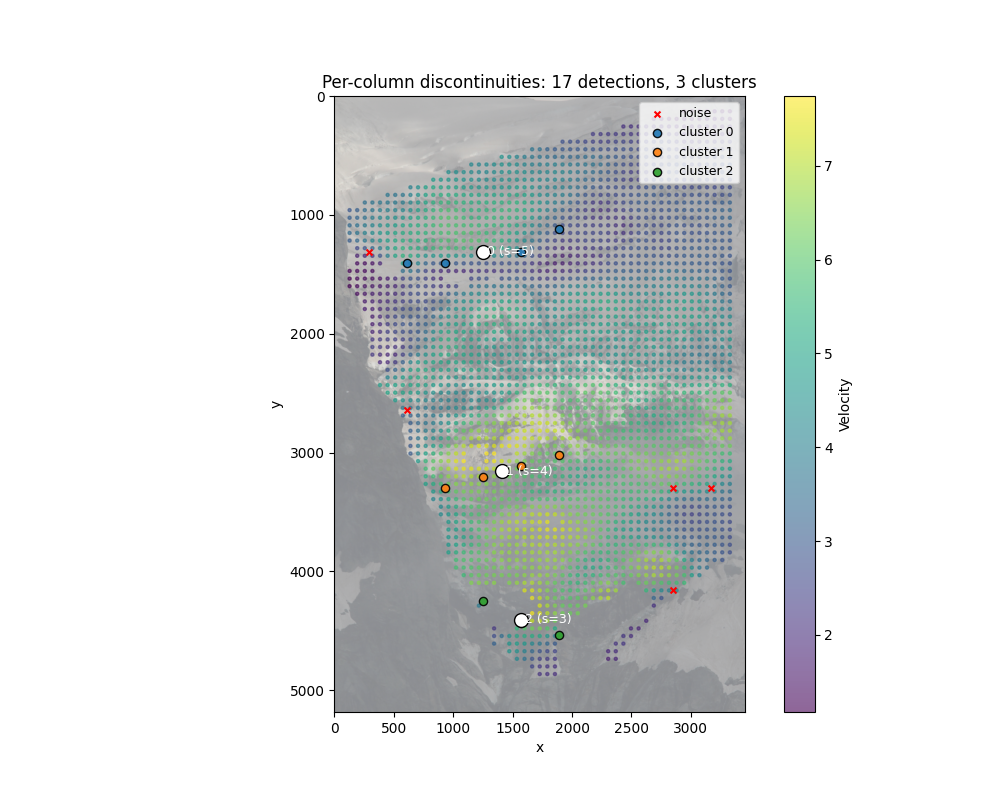

In [ ]:
from scipy import ndimage
from scipy.stats import binned_statistic
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


def find_vertical_discontinuities(
    x: np.ndarray,
    y: np.ndarray,
    v: np.ndarray,
    vertical_bins: int | None = None,
    horizontal_bins: int | None = None,
    bin_edges_h: np.ndarray | None = None,
    bin_centers_h: np.ndarray | None = None,
    bin_edges_v: np.ndarray | None = None,
    bin_centers_v: np.ndarray | None = None,
    min_points_per_bin_col: int = 5,
    gradient_threshold_factor: float = 0.3,
    smoothing_sigma_1d: float = 1.0,
    min_strength: float = 1e-3,
    cluster_eps_factor: float = 1.5,
    cluster_min_samples: int = 3,
):
    """
    For each horizontal column (bin_edges_h), build a 1D vertical velocity profile
    from the points inside that column, smooth it, compute dv/dy and detect local
    minima (negative peaks). Returns individual discontinuities and clustered ones.

    Outlier filtering is applied first on individual detections (strength + isolation),
    then DBSCAN is run on the surviving detections. Curve fitting removed: clusters
    are returned as collections of raw cluster points.
    """
    # define bins if not provided
    if bin_edges_h is None or bin_centers_h is None:
        if horizontal_bins is None:
            raise ValueError("Either horizontal_bins or bin_edges_h must be provided")

        # Define 2D bins
        bin_edges_h = np.linspace(x.min(), x.max(), horizontal_bins + 1)
        bin_centers_h = 0.5 * (bin_edges_h[:-1] + bin_edges_h[1:])

    if bin_edges_v is None or bin_centers_v is None:
        if vertical_bins is None:
            raise ValueError("Either vertical_bins or bin_edges_v must be provided")

        # Define 2D bins
        bin_edges_v = np.linspace(y.min(), y.max(), vertical_bins + 1)
        bin_centers_v = 0.5 * (bin_edges_v[:-1] + bin_edges_v[1:])

    # Compute bin widths and number of bins
    h_bin_width = np.mean(np.diff(bin_centers_h))
    v_bin_width = np.mean(np.diff(bin_centers_v))
    if vertical_bins is None:
        vertical_bins = len(bin_centers_v)

    # Collect per-column detections
    all_y = []
    all_x = []
    all_strengths = []
    all_col_indices = []
    for col in range(len(bin_centers_h)):
        # select points inside this horizontal bin (include right edge for last bin)
        x0, x1 = bin_edges_h[col], bin_edges_h[col + 1]
        if col == len(bin_centers_h) - 1:
            mask_col = (x >= x0) & (x <= x1)
        else:
            mask_col = (x >= x0) & (x < x1)

        if np.sum(mask_col) < min_points_per_bin_col:
            # not enough points in this column
            continue

        # compute vertical binned mean for this column
        col_counts = binned_statistic(
            y[mask_col], np.ones_like(y[mask_col]), statistic="count", bins=bin_edges_v
        ).statistic.astype(int)
        col_mean = binned_statistic(
            y[mask_col], v[mask_col], statistic="mean", bins=bin_edges_v
        ).statistic
        valid_mask_col = col_counts >= 1

        if not np.any(valid_mask_col):
            continue

        # fill invalid bins by nearest valid (so smoothing is meaningful)
        col_profile = np.copy(col_mean)
        valid_idx = np.where(valid_mask_col)[0]
        if len(valid_idx) == 0:
            continue
        for i in range(vertical_bins):
            if not valid_mask_col[i]:
                nearest = valid_idx[np.argmin(np.abs(valid_idx - i))]
                col_profile[i] = col_profile[nearest]

        # smooth 1D profile
        col_profile_smooth = ndimage.gaussian_filter1d(
            col_profile, sigma=smoothing_sigma_1d, mode="nearest"
        )

        # gradient dv/dy
        grad = np.gradient(col_profile_smooth) / v_bin_width

        # focus on negative gradients: threshold relative to minimum in this column
        min_grad = np.min(grad)
        if min_grad >= 0:
            # no negative structure in this column
            continue
        threshold = gradient_threshold_factor * min_grad  # negative value

        # find local minima (strict)
        for i in range(1, len(grad) - 1):
            if (
                valid_mask_col[i]
                and grad[i] < threshold
                and grad[i] < grad[i - 1]
                and grad[i] < grad[i + 1]
            ):
                pos_y = bin_centers_v[i]
                strength = abs(grad[i])
                # apply absolute strength filter
                if strength >= min_strength:
                    all_y.append(pos_y)
                    all_x.append(bin_centers_h[col])
                    all_strengths.append(strength)
                    all_col_indices.append(col)

    # no detections
    if len(all_y) == 0:
        return {
            "individual": {
                "x": np.array([]),
                "y": np.array([]),
                "strength": np.array([]),
                "col_idx": np.array([]),
                "labels": np.array([], dtype=int),
            },
            "clustered": [],
        }

    # Prepare arrays
    XY = np.column_stack((np.array(all_x), np.array(all_y)))
    all_strengths_arr = np.array(all_strengths)
    all_cols_arr = np.array(all_col_indices)

    # compute clustering radius
    h_bin_width = np.median(np.diff(bin_centers_h))
    eps = max(v_bin_width * cluster_eps_factor, h_bin_width * cluster_eps_factor)

    # --- OUTLIER FILTERING ON INDIVIDUAL DETECTIONS ---
    # Compute median strength (fallback if empty)
    median_strength = np.median(all_strengths_arr) if all_strengths_arr.size else 0.0

    # Use a conservative strength threshold (keep weak but consistent detections).
    # This avoids discarding spatially-coherent low-strength detections (e.g. an upper cluster).
    strength_thresh = max(min_strength, 0.3 * median_strength)

    # Spatial isolation: require at least `required_neighbors` within eps (including self).
    # Use 1 as minimum to avoid dropping isolated-but-valid detections.
    required_neighbors = max(1, cluster_min_samples)

    nbrs = NearestNeighbors(radius=eps).fit(XY)
    neighbors = nbrs.radius_neighbors(XY, return_distance=False)
    neighbor_counts = np.array([len(nb) for nb in neighbors])

    # Also compute how many detections fall in the same column: if a detection is supported
    # by other detections in the same column, keep it (prevents dropping vertical stacks).
    col_support_counts = np.array([np.sum(all_cols_arr == c) for c in all_cols_arr])

    # Keep detections that pass strength & neighbor tests OR have column support >= 2
    keep_mask = (
        (all_strengths_arr >= strength_thresh) & (neighbor_counts >= required_neighbors)
    ) | (col_support_counts >= 2)

    # If nothing passes filtering, relax strength threshold a bit and allow neighbor_counts >= 1
    if not np.any(keep_mask):
        strength_thresh_relaxed = max(min_strength, 0.2 * median_strength)
        keep_mask = (
            (all_strengths_arr >= strength_thresh_relaxed) & (neighbor_counts >= 1)
        ) | (col_support_counts >= 2)

    # Keep filtered detections for clustering
    XY_filtered = XY[keep_mask]
    strengths_filtered = all_strengths_arr[keep_mask]
    cols_filtered = all_cols_arr[keep_mask]
    original_indices = np.where(keep_mask)[0]

    if XY_filtered.shape[0] == 0:
        # nothing left after filtering
        return {
            "individual": {
                "x": np.array(all_x),
                "y": np.array(all_y),
                "strength": np.array(all_strengths),
                "col_idx": np.array(all_col_indices),
                "labels": -1 * np.ones(len(all_y), dtype=int),
            },
            "clustered": [],
        }

    # --- CLUSTERING ---
    clustering = DBSCAN(eps=eps, min_samples=cluster_min_samples).fit(XY_filtered)
    labels_filtered = clustering.labels_

    # Map labels back to full detection list (-1 for filtered-out or noise)
    labels_all = -1 * np.ones(XY.shape[0], dtype=int)
    labels_all[original_indices] = labels_filtered

    clustered_boundaries = []
    unique_labels = sorted(set(labels_filtered))
    for lab in unique_labels:
        if lab == -1:
            continue
        mask_f = labels_filtered == lab
        pts = XY_filtered[mask_f]
        strg = strengths_filtered[mask_f]
        cols = cols_filtered[mask_f]

        # require cluster to span at least 2 columns
        support_cols = np.unique(cols).size
        if support_cols < 2:
            continue

        mean_y = float(np.mean(pts[:, 1]))
        mean_x = float(np.mean(pts[:, 0]))
        mean_strength = float(np.mean(strg))

        clustered_boundaries.append(
            {
                "label": int(lab),
                "position": mean_y,
                "x_mean": mean_x,
                "strength": mean_strength,
                "support": int(support_cols),
                "raw_xy": pts,
                "raw_strengths": strg,
                "columns": cols,
            }
        )

    # If no cluster survives, try to relax a bit (lower min_samples)
    if len(clustered_boundaries) == 0 and cluster_min_samples > 2:
        return find_vertical_discontinuities(
            x,
            y,
            v,
            vertical_bins=vertical_bins,
            horizontal_bins=horizontal_bins,
            bin_edges_h=bin_edges_h,
            bin_centers_h=bin_centers_h,
            bin_edges_v=bin_edges_v,
            bin_centers_v=bin_centers_v,
            min_points_per_bin_col=min_points_per_bin_col,
            gradient_threshold_factor=gradient_threshold_factor,
            smoothing_sigma_1d=smoothing_sigma_1d,
            min_strength=min_strength,
            cluster_eps_factor=cluster_eps_factor,
            cluster_min_samples=max(2, cluster_min_samples - 1),
        )

    # sort clusters by y (top -> bottom)
    clustered_boundaries.sort(key=lambda b: b["position"], reverse=True)

    return {
        "individual": {
            "x": np.array(all_x),
            "y": np.array(all_y),
            "strength": np.array(all_strengths),
            "col_idx": np.array(all_col_indices),
            "labels": labels_all,  # -1 = noise / removed
        },
        "clustered": clustered_boundaries,
    }


def plot_discontinuities(
    x: np.ndarray,
    y: np.ndarray,
    v: np.ndarray,
    discontinuities: dict,
    img=None,
    ax=None,
):
    inds = discontinuities["individual"]

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    if img is not None:
        ax.imshow(img, alpha=0.5, cmap="gray")

    # plot all input points colored by full velocity field for context
    scatter = ax.scatter(x, y, c=v, cmap="viridis", s=5, alpha=0.6)
    plt.colorbar(scatter, label="Velocity")

    # per-column detections: color by DBSCAN label (if available)
    det_x = inds["x"]
    det_y = inds["y"]
    det_strength = inds["strength"]
    det_labels = inds.get("labels", -1 * np.ones_like(det_x, dtype=int))

    # plot noise (label == -1) as small red crosses
    noise_mask = det_labels == -1
    if np.any(noise_mask):
        ax.scatter(
            det_x[noise_mask],
            det_y[noise_mask],
            c="red",
            s=18,
            marker="x",
            label="noise",
        )

    # plot clustered detections with distinct colors
    cluster_labels = np.unique(det_labels[det_labels != -1])
    cmap = plt.get_cmap("tab10")
    for i, cl in enumerate(cluster_labels):
        mask = det_labels == cl
        color = cmap(i % 10)
        ax.scatter(
            det_x[mask],
            det_y[mask],
            c=[color],
            s=35,
            edgecolor="k",
            alpha=0.9,
            label=f"cluster {cl}",
        )

    # also plot cluster centroids and support
    for b in discontinuities.get("clustered", []):
        ax.plot(
            b["x_mean"],
            b["position"],
            marker="o",
            markersize=10,
            color="white",
            markeredgecolor="k",
        )
        ax.text(
            b["x_mean"],
            b["position"],
            f" {b['label']} (s={b['support']})",
            color="white",
            fontsize=9,
            va="center",
        )

    ax.legend(loc="upper right", fontsize=9)
    ax.set_title(
        f"Per-column discontinuities: {len(det_y)} detections, {len(discontinuities['clustered'])} clusters"
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    plt.show()


# Use the smoothed dataframe finding morpho-kinematic boundaries
df_smooth = apply_2d_gaussian_filter(df, sigma=1)
x = df_smooth["x"].to_numpy()
y = df_smooth["y"].to_numpy()
v = df_smooth["V"].to_numpy()

discontinuity_results = find_vertical_discontinuities(
    x=x,
    y=y,
    v=v,
    vertical_bins=50,
    horizontal_bins=10,
    min_points_per_bin_col=20,  # try 5-20 depending on data density
    gradient_threshold_factor=0.3,  # # Threshold for significant gradient (as fraction of max) adjust to be more/less sensitive
    smoothing_sigma_1d=1.0,
    min_strength=1e-3,
    cluster_eps_factor=2.0,
    cluster_min_samples=5,
)
fig, ax = plt.subplots(figsize=(10, 8))
plot_discontinuities(
    x,
    y,
    v,
    discontinuities=discontinuity_results,
    img=img,
    ax=ax,
)

2025-09-26 14:36:23 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=3
2025-09-26 14:36:23 | [INFO    ] Estimated grid spacing: 64.00


2025-09-26 14:36:23 | [INFO    ] Created 2D grid: (75, 51), 2690 valid points
2025-09-26 14:36:23 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0
/tmp/ipykernel_927286/1120454366.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


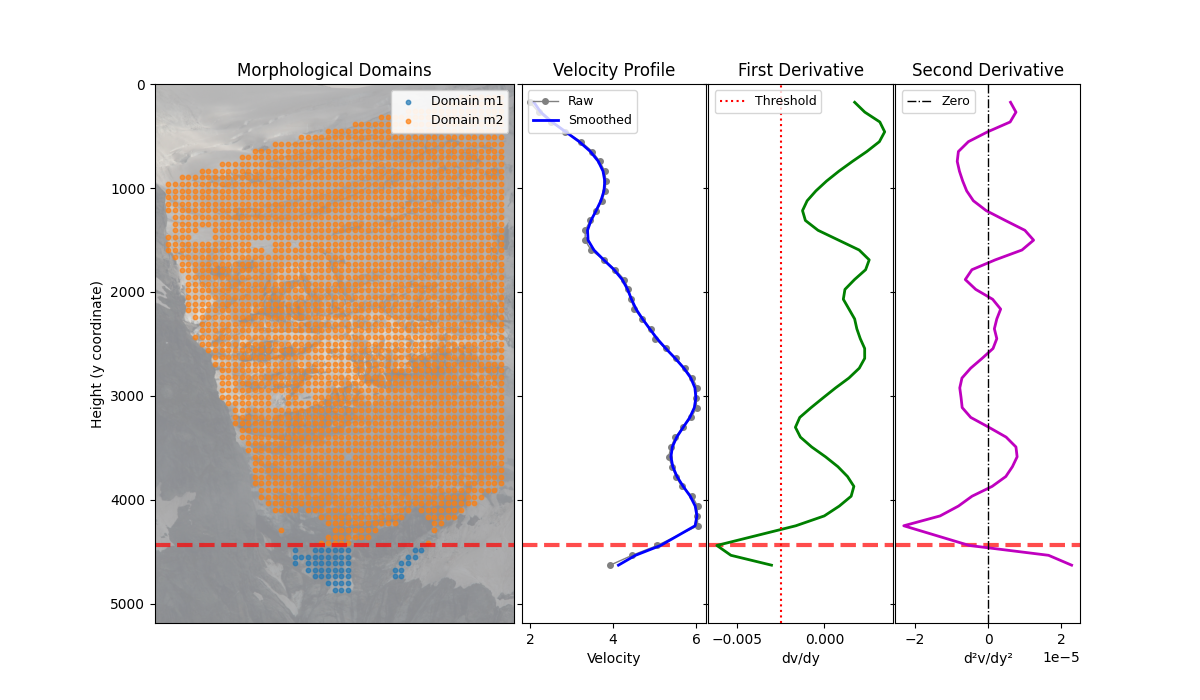

In [54]:
# 1-D binning approach

vertical_bins = 50
min_points_per_bin = 10
gradient_threshold = 0.4
smoothing_sigma = 1.0

# Use the smoothed dataframe finding morpho-kinematic boundaries
df_smooth = apply_2d_gaussian_filter(df, sigma=3)
x = df_smooth["x"].to_numpy()
y = df_smooth["y"].to_numpy()
v = df_smooth["V"].to_numpy()

# Compute bin statistics
y_min, y_max = y.min(), y.max()
bin_edges = np.linspace(y_min, y_max, vertical_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

count_binned = binned_statistic(y, np.ones_like(y), statistic="count", bins=bin_edges)
mean_binned = binned_statistic(y, v, statistic="mean", bins=bin_edges)
points_per_bin = count_binned.statistic.astype(int)
valid_bins = points_per_bin >= min_points_per_bin
mean_velocities = np.where(valid_bins, mean_binned.statistic, 0.0)

# Apply smoothing to velocity profile for valid bins only
if np.sum(valid_bins) > 3:
    # Create continuous array for smoothing
    valid_indices = np.where(valid_bins)[0]
    valid_centers = bin_centers[valid_indices]
    valid_velocities = mean_velocities[valid_indices]

    # Fill invalid bins with nearest neighbor values for smoothing
    smoothed_velocities = mean_velocities.copy()
    for i in range(vertical_bins):
        if not valid_bins[i] and len(valid_indices) > 0:
            nearest_idx = valid_indices[np.argmin(np.abs(valid_indices - i))]
            smoothed_velocities[i] = smoothed_velocities[nearest_idx]

    # Apply Gaussian smoothing
    smoothed_velocities = ndimage.gaussian_filter1d(
        smoothed_velocities, sigma=smoothing_sigma
    )
else:
    smoothed_velocities = mean_velocities.copy()

# Calculate velocity gradient (derivative)
bin_width = np.mean(mean_binned.bin_edges[1:] - mean_binned.bin_edges[:-1])
vel_gradient = np.gradient(smoothed_velocities) / bin_width

# Calculate second derivative
vel_second_derivative = np.gradient(vel_gradient) / bin_width

# Identify significant velocity transitions using gradient threshold
# Focusing on negative gradients (velocity decreases moving upward)
gradient_threshold_value = gradient_threshold * np.min(vel_gradient)
transition_indices = []
transition_strengths = []
for i in range(1, len(vel_gradient) - 1):
    # Skip bins with too few points
    if not valid_bins[i]:
        continue

    # Check for significant negative gradient (velocity decrease)
    # Verify this is a peak in the gradient (local minimum)
    if (
        (vel_gradient[i] < gradient_threshold_value)
        and (vel_gradient[i] < vel_gradient[i - 1])
        and (vel_gradient[i] < vel_gradient[i + 1])
    ):
        transition_indices.append(i)
        transition_strengths.append(abs(vel_gradient[i]))

# Convert transition indices to y-coordinates
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
boundaries = [bin_centers[i] for i in transition_indices]

# If no transitions found, raise a warning
if len(boundaries) < 1:
    logger.warning("No morpho boundaries detected. Assigning single domain.")

    # Assign all points to a single domain
    morpho_domains = np.zeros_like(x, dtype=int)
    morpho_domains_map = {"m1": 0}

# Sort boundaries from bottom to top (highest y to lowest y)
sorted_boundaries = sorted(boundaries, reverse=True)

# Assign domain labels with letters starting from A at the bottom upwards
morpho_domains = np.zeros_like(x, dtype=int)
morpho_domains_map = {}

# Domain m1 is at the bottom (highest y values)
morpho_domains[(y >= sorted_boundaries[0])] = 0  # Domain m1 (bottom)
morpho_domains_map["m1"] = 0

# Middle domains if multiple boundaries
for i in range(len(sorted_boundaries) - 1):
    morpho_domains[(y < sorted_boundaries[i]) & (y >= sorted_boundaries[i + 1])] = i + 1
    morpho_domains_map[f"m{i + 2}"] = i + 1  # m2, m3, m4...

# Upper domain (top of image, lowest y values)
morpho_domains[(y < sorted_boundaries[-1])] = len(sorted_boundaries)
morpho_domains_map[f"m{len(sorted_boundaries) + 1}"] = len(sorted_boundaries)

colormap = plt.get_cmap("tab10")

# Create figure with shared y-axis
fig = plt.figure(figsize=(12, 7))

gs = fig.add_gridspec(1, 4, width_ratios=[2, 1, 1, 1], wspace=0.01)

# Create axes with shared y-axis
ax1 = fig.add_subplot(gs[0, 0])  # Domain visualization
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)  # Velocity profile
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)  # Velocity gradient
ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)  # Second derivative

# 1. Domains visualization

# 1. Domains visualization
ax1.imshow(img, alpha=0.5, cmap="gray")
for i, (label, domain_id) in enumerate(morpho_domains_map.items()):
    mask = morpho_domains == domain_id
    ax1.scatter(
        x[mask],
        y[mask],
        color=colormap(i),
        label=f"Domain {label}",
        s=10,
        alpha=0.7,
    )

# Draw horizontal boundary lines on all panels
for i, bound in enumerate(boundaries):
    strength = (
        transition_strengths[i] / max(transition_strengths)
        if transition_strengths
        else 1.0
    )
    for ax in [ax1, ax2, ax3, ax4]:
        ax.axhline(
            y=bound,
            color="red",
            linestyle="--",
            linewidth=1 + 2 * strength,
            alpha=0.7,
        )

# 2. Velocity profile with transitions
ax2.plot(
    mean_velocities[valid_bins],
    bin_centers[valid_bins],
    "o-",
    color="gray",
    markersize=4,
    linewidth=1,
    label="Raw",
)
ax2.plot(
    smoothed_velocities[valid_bins],
    bin_centers[valid_bins],
    "b-",
    linewidth=2,
    label="Smoothed",
)

# 3. Velocity gradient (first derivative)
ax3.plot(vel_gradient[valid_bins], bin_centers[valid_bins], "g-", linewidth=2)
ax3.axvline(x=gradient_threshold_value, color="r", linestyle=":", label="Threshold")

# 4. Second derivative
ax4.plot(vel_second_derivative[valid_bins], bin_centers[valid_bins], "m-", linewidth=2)
# Highlight zero crossings that indicate inflection points
zero_line = ax4.axvline(x=0, color="k", linestyle="-.", linewidth=1, label="Zero")

# Set titles and labels
ax1.set_title("Morphological Domains")
ax1.set_xlabel("")
ax1.set_xticks([])
ax1.set_ylabel("Height (y coordinate)")

ax2.set_title("Velocity Profile")
ax2.set_xlabel("Velocity")
ax2.tick_params(axis="y", labelright=False, labelleft=False)

ax3.set_title("First Derivative")
ax3.set_xlabel("dv/dy")
ax3.tick_params(axis="y", labelright=False, labelleft=False)

ax4.set_title("Second Derivative")
ax4.set_xlabel("d²v/dy²")
ax4.tick_params(axis="y", labelright=False, labelleft=False)

# Add legends
ax1.legend(loc="upper right", frameon=True, framealpha=0.9, fontsize=9)
ax2.legend(loc="upper left", fontsize=9)
ax3.legend(loc="upper left", fontsize=9)
ax4.legend(loc="upper left", fontsize=9)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig(
    output_dir / f"{reference_start_date}_{reference_end_date}_velocity_analysis.png",
    dpi=300,
    bbox_inches="tight",
)


## RUN MCMC multiple times with different smoothing scales and median the clustering results


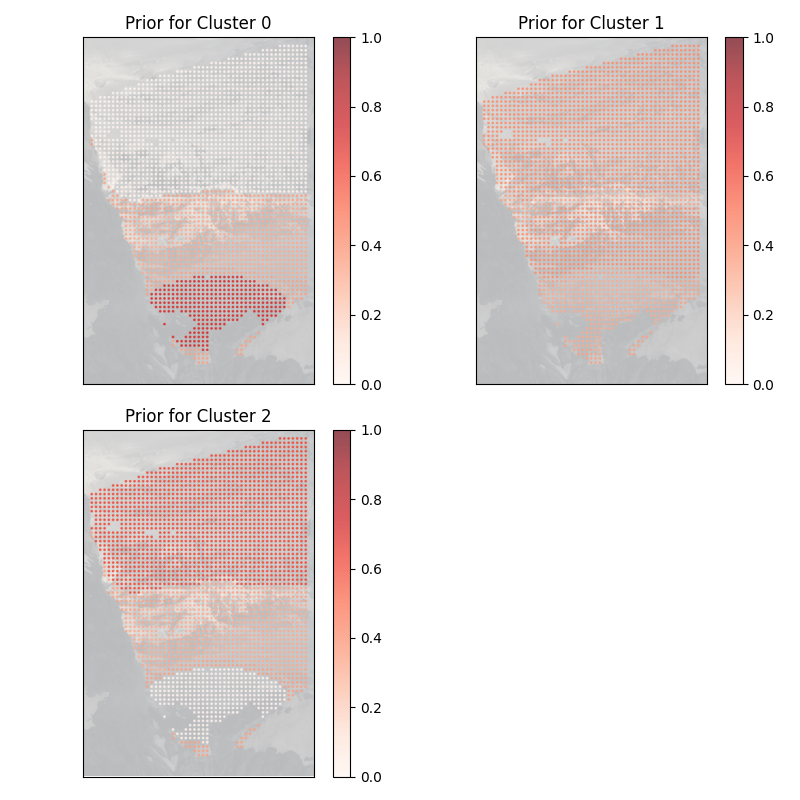

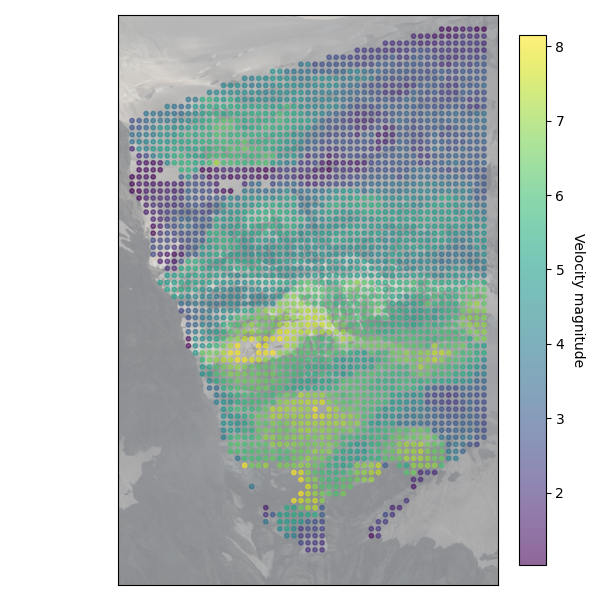

In [55]:
sigma_values = [2, 3]  # Different Gaussian smoothing scales

# Assign spatial priors
prior_probs = assign_spatial_priors(
    x=df["x"].to_numpy(),
    y=df["y"].to_numpy(),
    polygons=sectors,
    prior_probs=PRIOR_PROBABILITY,
    # method="exponential",
    # method_kws={"decay_rate": 0.001},
)

fig, axes = plot_spatial_priors(df, prior_probs, img=img)
fig.savefig(
    output_dir / f"{base_name}_spatial_priors.jpg",
    dpi=150,
    bbox_inches="tight",
)

# Plot velocity field
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_velocity_magnitude(
    df["x"].to_numpy(),
    df["y"].to_numpy(),
    df["V"].to_numpy(),
    img=img,
    ax=ax,
)
fig.savefig(
    output_dir / f"{base_name}_velocity_field.jpg",
    dpi=150,
    bbox_inches="tight",
)

In [56]:
## Helper function to preprocess velocity features


def preprocess_velocity_features(
    velocities,
    velocity_transform="power",
    velocity_params=None,
):
    """
    Preprocess velocity features with various transformation options.

    Parameters:
    -----------
    velocities : numpy.ndarray
        1D array of velocity magnitudes
    velocity_transform : str, default="power"
        Type of velocity transformation: "power", "exponential", "threshold", "sigmoid", or "none"
    velocity_params : dict, optional
        Parameters for velocity transformation. Defaults depend on transform type:
        - "power": {"exponent": 2}
        - "exponential": {"scale": 0.2}
        - "threshold": {"threshold_percentile": 50, "enhancement": 3.0}
        - "sigmoid": {"midpoint_percentile": 70, "steepness": 2.0}
        - "none": {}

            Returns:
    --------
    tuple : (velocities_transformed, transform_info)
        - velocities_transformed: numpy.ndarray of transformed velocities
        - transform_info: Dictionary with transformation metadata
    """
    # Ensure input is numpy array
    velocities = np.asarray(velocities)

    # Set default velocity transformation parameters
    if velocity_params is None:
        velocity_params = {
            "power": {"exponent": 2},
            "exponential": {"scale": 0.2},
            "threshold": {"threshold_percentile": 50, "enhancement": 3.0},
            "sigmoid": {"midpoint_percentile": 70, "steepness": 2.0},
            "none": {},
        }.get(velocity_transform, {})

    # Apply velocity transformation
    if velocity_transform == "power":
        exponent = velocity_params.get("exponent", 2)
        velocities_transformed = velocities**exponent
        transform_info = {"type": "power", "exponent": exponent}

    elif velocity_transform == "exponential":
        scale = velocity_params.get("scale", 0.2)
        velocities_transformed = np.exp(scale * velocities) - 1
        transform_info = {"type": "exponential", "scale": scale}

    elif velocity_transform == "threshold":
        threshold_percentile = velocity_params.get("threshold_percentile", 50)
        enhancement = velocity_params.get("enhancement", 3.0)
        threshold = np.percentile(velocities, threshold_percentile)
        velocities_transformed = np.where(
            velocities > threshold,
            velocities * enhancement,
            velocities,
        )
        transform_info = {
            "type": "threshold",
            "threshold": threshold,
            "enhancement": enhancement,
        }

    elif velocity_transform == "sigmoid":
        midpoint_percentile = velocity_params.get("midpoint_percentile", 70)
        steepness = velocity_params.get("steepness", 2.0)
        midpoint = np.percentile(velocities, midpoint_percentile)
        velocities_transformed = 1 / (1 + np.exp(-steepness * (velocities - midpoint)))
        transform_info = {
            "type": "sigmoid",
            "midpoint": midpoint,
            "steepness": steepness,
        }

    else:  # "none" or any other value
        logger.info("No velocity transformation applied.")
        return velocities, {"type": "none"}

    logger.info(
        f"Applied {velocity_transform} transformation with params: {velocity_params}"
    )
    logger.info(f"Feature shape: {velocities_transformed.shape}")

    return velocities_transformed, transform_info


def run_mcmc_clustering(
    df_input,
    prior_probs,
    sectors,
    output_dir,
    base_name,
    img=None,
    variables_names=None,
    transform_velocity="none",
    transform_params=None,
    mu_params=None,
    sigma_params=None,
    feature_weights=None,
    sample_args=None,
    random_seed=8927,
):
    """
    Run MCMC-based clustering on velocity data with flexible velocity transformations.

    Parameters:
    -----------
    df_input : pandas.DataFrame
        Input dataframe with 'x', 'y', 'V' columns
    transform_velocity : str, default="none"
        Type of velocity transformation: "power", "exponential", "threshold", "sigmoid", or "none"
    transform_params : dict, optional
        Parameters for velocity transformation (see preprocess_velocity_features for details)
    """
    logger.info(f"Running MCMC clustering for {base_name}...")

    # Make a copy to avoid modifying the input
    # df_run = df_input.copy()

    # Default parameters if not provided
    if mu_params is None:
        mu_params = {"mu": 0, "sigma": 1}
    if sigma_params is None:
        sigma_params = {"sigma": 1}
    if sample_args is None:
        sample_args = dict(
            target_accept=0.95,
            draws=2000,
            tune=1000,
            chains=4,
            cores=4,
            random_seed=random_seed,
        )
    if variables_names is None:
        variables_names = ["V"]

    if "V" not in df_input.columns:
        raise ValueError("Input dataframe must contain 'V' column for velocities.")

    # Preprocess velocity features to enhance high velocities
    velocities, transform_info = preprocess_velocity_features(
        velocities=df_input["V"].to_numpy(),
        velocity_transform=transform_velocity,
        velocity_params=transform_params,
    )

    # Extract data array for clustering
    if len(variables_names) > 1:
        # Concatenate other features to velocities
        additional_vars = variables_names.copy()
        if "V" in additional_vars:
            additional_vars.remove("V")
        additional_data = df_input[additional_vars].to_numpy()
        data_array = np.column_stack((velocities, additional_data))
    else:
        # Use only velocities
        data_array = velocities.reshape(-1, 1)

    scaler = StandardScaler()
    scaler.fit(data_array)
    joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")

    # Scale data for model input
    data_array_scaled = scaler.transform(data_array)

    # Build model
    logger.info(f"Running MCMC clustering for {base_name}...")
    model = build_marginalized_mixture_model(
        data_array_scaled,
        prior_probs,
        sectors,
        mu_params=mu_params,
        sigma_params=sigma_params,
        feature_weights=feature_weights,
    )

    # Sample model
    idata, convergence_flag = sample_model(model, output_dir, base_name, **sample_args)
    if not convergence_flag:
        idata_summary = az.summary(idata, var_names=["mu", "sigma"])
        logger.info(f"MCMC did not converge. Summary:\n{idata_summary}")

    # Compute cluster assignments
    # if transform_params != "none":
    #     posterior_probs, cluster_pred, uncertainty = (
    #         compute_posterior_assignments_with_scaling(
    #             idata,
    #             scaler,
    #             transform_info,
    #             original_velocities=df_input["V"].to_numpy(),
    #             n_posterior_samples=200,
    #         )
    #     )
    # else:
    posterior_probs, cluster_pred, uncertainty = compute_posterior_assignments(
        idata, n_posterior_samples=200
    )

    # Generate plots
    fig = plot_velocity_clustering(
        df_features=df_input,  # Use original data for plotting
        img=img,
        idata=idata,
        cluster_pred=cluster_pred,
        posterior_probs=posterior_probs,
        scaler=scaler,
    )
    fig.savefig(
        output_dir / f"{base_name}_results.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.close(fig)

    # Trace plots
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    az.plot_trace(
        idata, var_names=["mu", "sigma"], axes=axes, compact=True, legend=True
    )
    fig.savefig(output_dir / f"{base_name}_trace_plots.png", dpi=150)
    plt.close(fig)

    # Forest plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    az.plot_forest(idata, var_names=["mu", "sigma"], combined=True, ess=True, ax=axes)
    fig.savefig(output_dir / f"{base_name}_forest_plot.png", dpi=150)
    plt.close(fig)

    # Collect and save metadata
    metadata = collect_run_metadata(
        idata=idata,
        convergence_flag=convergence_flag,
        data_array_scaled=data_array_scaled,
        variables_names=variables_names,
        sectors=sectors,
        prior_probs=prior_probs,
        sample_args=sample_args,
        frame=locals(),
    )
    save_run_metadata(output_dir, base_name, metadata)

    # Return results dictionary
    result = {
        "metadata": metadata,
        "idata": idata,
        "scaler": scaler,
        "convergence_flag": convergence_flag,
        "posterior_probs": posterior_probs,
        "cluster_pred": cluster_pred,
        "uncertainty": uncertainty,
    }

    plt.close("all")
    return result


def aggregate_multiscale_clustering(
    results, similarity_threshold=0.6, overall_threshold=0.7, fig_path=None
):
    """
    Aggregate clustering results across scales, filtering unstable scales.

    Parameters:
    -----------
    results : list of dict
        Results from different scale clustering runs
    similarity_threshold : float
        Minimum mean similarity for a scale to be included
    overall_threshold : float
        Minimum overall similarity across scales to accept results

    Returns:
    --------
    combined_cluster_pred : ndarray
        Aggregated cluster assignments
    stability_score : float
        Measure of overall stability (0-1)
    """

    # Extract all cluster predictions
    all_cluster_preds = np.array([res["cluster_pred"] for res in results])
    n_scales = len(all_cluster_preds)
    sigma_values = [res["sigma"] for res in results]

    # Calculate pairwise similarities
    similarity_matrix = np.zeros((n_scales, n_scales))
    np.fill_diagonal(similarity_matrix, 1.0)
    for i, j in combinations(range(n_scales), 2):
        sim = adjusted_rand_score(all_cluster_preds[i], all_cluster_preds[j])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim

    # Plot similarity heatmap
    if fig_path is not None:
        fig_path = Path(fig_path)
        fig_path.parent.mkdir(parents=True, exist_ok=True)
        fig, ax = plt.subplots(figsize=(4, 4))
        sns.heatmap(
            similarity_matrix,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            xticklabels=sigma_values,
            yticklabels=sigma_values,
        )
        plt.title("Adjusted Rand Index Between Scales")
        plt.xlabel("Sigma")
        plt.ylabel("Sigma")
        plt.tight_layout()
        fig.savefig(fig_path, dpi=100, bbox_inches="tight")
        plt.close(fig)

    # Calculate mean similarity for each scale (exclude self-similarity)
    mean_similarities = (similarity_matrix.sum(axis=1) - 1) / (n_scales - 1)

    # Filter scales with low similarity
    valid_scales = mean_similarities >= similarity_threshold
    if not np.any(valid_scales):
        raise ValueError(
            f"No scales meet the similarity threshold of {similarity_threshold}. "
            f"Mean similarities: {mean_similarities}"
        )

    # Get overall stability score (mean of valid scale similarities)
    valid_sim_matrix = similarity_matrix[np.ix_(valid_scales, valid_scales)]
    stability_score = valid_sim_matrix.mean()
    logger.info(f"Overall stability score: {stability_score:.2f}")

    # Check if overall stability is too low
    if stability_score < overall_threshold:
        raise ValueError(
            f"Overall clustering stability ({stability_score:.2f}) is below threshold "
            f"({overall_threshold}). Results are too unstable across scales."
        )

    # Get valid cluster predictions and compute mode
    valid_preds = all_cluster_preds[valid_scales]
    logger.info(
        f"Using {sum(valid_scales)}/{n_scales} scales: sigma={np.array(sigma_values)[valid_scales]}"
    )

    # Compute mode (most common label at each point)
    combined_cluster_pred, _ = mode(valid_preds, axis=0)
    combined_cluster_pred = combined_cluster_pred.flatten()

    # Compute also average posterior probabilities, entropy and assignment uncertainty
    avg_posterior_probs = np.mean([res["posterior_probs"] for res in results], axis=0)
    avg_entropy = -np.sum(
        avg_posterior_probs * np.log(avg_posterior_probs + 1e-10), axis=1
    )

    # Aggregate results in a dictionary
    aggregated_results = {
        "combined_cluster_pred": combined_cluster_pred,
        "similarity_matrix": similarity_matrix,
        "stability_score": stability_score,
        "valid_scales": np.array(sigma_values)[valid_scales].tolist(),
        "avg_posterior_probs": avg_posterior_probs,
        "avg_entropy": avg_entropy,
    }

    return aggregated_results


def add_second_derivative_feature(
    df, y_values, bin_centers, vel_second_derivative, valid_bins=None
):
    """
    Sample the second derivative profile at each point's y-coordinate
    and add it as a new feature to the dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with 'y' coordinates
    y_values : array-like
        Y coordinates of points
    bin_centers : array-like
        Centers of bins used for velocity profile analysis
    vel_second_derivative : array-like
        Second derivative values for each bin
    valid_bins : array-like, optional
        Boolean mask of valid bins

    Returns:
    --------
    pandas.DataFrame
        Copy of input dataframe with new 'd2v_dy2' column
    """
    # Create a copy of the dataframe
    df_with_feature = df.copy()

    # Use only valid bins for interpolation if provided
    if valid_bins is not None:
        valid_bin_centers = bin_centers[valid_bins]
        valid_derivatives = vel_second_derivative[valid_bins]
    else:
        valid_bin_centers = bin_centers
        valid_derivatives = vel_second_derivative

    # Create a 1D interpolation function (linear)
    # Use 'bounds_error=False' to handle points outside the range
    # and 'fill_value="extrapolate"' to extrapolate beyond the bounds
    d2v_interp = interpolate.interp1d(
        valid_bin_centers,
        valid_derivatives,
        kind="linear",
        bounds_error=False,
        fill_value="extrapolate",
    )

    # Sample the function at each point's y-coordinate
    d2v_sampled = d2v_interp(y_values)

    # Add as a new feature to the dataframe
    df_with_feature["d2v_dy2"] = d2v_sampled

    # Visualize the sampled second derivative values to confirm they look correct
    # fig, ax = plt.subplots(figsize=(10, 8))
    # scatter = ax.scatter(
    #     df_with_feature["x"],
    #     df_with_feature["y"],
    #     c=df_with_feature["d2v_dy2"],
    #     cmap="coolwarm",
    #     s=10,
    #     alpha=0.7,
    # )
    # plt.colorbar(scatter, label="d²v/dy²")
    # ax.set_aspect("equal")
    # ax.set_title("Second Derivative Values")

    return df_with_feature, d2v_sampled

In [57]:
# Define sigma values for Gaussian smoothing
sigma_values = [2]
variables_names = ["V"]

if "d2v_dy2" in variables_names:
    # Sample the second derivative at each point's y-coordinate and add as new feature
    df, d2v_sampled = add_second_derivative_feature(
        df=df,
        y_values=df["y"].to_numpy(),
        bin_centers=bin_centers,
        vel_second_derivative=vel_second_derivative,
        valid_bins=valid_bins,
    )


# Loop through smoothing scales
results = []
for sigma in sigma_values:
    logger.info(f"Processing with Gaussian smoothing sigma={sigma}...")

    # Create scale-specific base name
    scale_base_name = f"{reference_start_date}_{reference_end_date}_sigma{sigma}"

    # Apply Gaussian smoothing if needed
    df_run = apply_2d_gaussian_filter(df, sigma=sigma) if sigma > 0 else df.copy()

    # Adjust model parameters based on scale
    mu_params = {"mu": 0, "sigma": 1 if sigma <= 2 else 0.5}
    sigma_params = {"sigma": 1 if sigma <= 2 else 0.5}

    # Run MCMC clustering with the smoothed data
    result = run_mcmc_clustering(
        df_input=df_run,
        prior_probs=prior_probs,
        sectors=sectors,
        variables_names=variables_names,
        output_dir=output_dir,
        base_name=scale_base_name,
        img=img,
        transform_velocity="sigmoid",
        transform_params={"midpoint_percentile": 70, "steepness": 2.0},
        mu_params=mu_params,
        sigma_params=sigma_params,
        random_seed=RANDOM_SEED,
    )

    # Add scale information to result
    result["sigma"] = sigma

    # Append to results list
    results.append(result)

# Save all results to a single joblib file
# joblib.dump(
#     results,
#     output_dir
#     / f"{reference_start_date}_{reference_end_date}_all_results_multiscale.joblib",
# )

2025-09-26 14:36:41 | [INFO    ] Processing with Gaussian smoothing sigma=2...
2025-09-26 14:36:41 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=2
2025-09-26 14:36:41 | [INFO    ] Estimated grid spacing: 64.00
2025-09-26 14:36:41 | [INFO    ] Created 2D grid: (75, 51), 2690 valid points
2025-09-26 14:36:41 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0
2025-09-26 14:36:41 | [INFO    ] Running MCMC clustering for 2024-06-22_2024-06-22_sigma2...
2025-09-26 14:36:41 | [INFO    ] Applied sigmoid transformation with params: {'midpoint_percentile': 70, 'steepness': 2.0}
2025-09-26 14:36:41 | [INFO    ] Feature shape: (2690,)
2025-09-26 14:36:41 | [INFO    ] Running MCMC clustering for 2024-06-22_2024-06-22_sigma2...
2025-09-26 14:36:41 | [INFO    ] Marginalized mixture model (un-sampled) created.
2025-09-26 14:36:41 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 ch

Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.
2025-09-26 14:37:43 | [INFO    ] Sampling completed.
/home/francesco/ppcx/ppcx-domains/src/ppcluster/mcmc.py:716: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(
2025-09-26 14:37:53 | [WARNING ] This function is temporary and it will be replaced by a more structured configuration system.
2025-09-26 14:37:53 | [INFO    ] Experiment metadata saved to output/PPCX_Tele_2024-06-22_mcmc_multiscale/2024-06-22_2024-06-22_sigma2_metadata.json


In [58]:
# Read the results again
# results = joblib.load(
#     output_dir
#     / f"{reference_start_date}_{reference_end_date}_all_results_multiscale.joblib",
# )

In [62]:
# ===  If a multi-scale approach was used, aggregate the results.
if len(sigma_values) > 1:
    aggregated_results = aggregate_multiscale_clustering(
        results,
        similarity_threshold=0.7,
        overall_threshold=0.8,
        fig_path=output_dir
        / f"{reference_start_date}_{reference_end_date}_similarity_heatmap.jpg",
    )

    # Unpack aggregated results
    cluster_pred = aggregated_results["combined_cluster_pred"]
    posterior_probs = aggregated_results["avg_posterior_probs"]
    entropy = aggregated_results["avg_entropy"]
    similarity_matrix = aggregated_results["similarity_matrix"]
    stability_score = aggregated_results["stability_score"]
    valid_scales = aggregated_results["valid_scales"]

else:
    # Otherwise extract the single result
    cluster_pred = results[0]["cluster_pred"]
    posterior_probs = results[0]["posterior_probs"]
    entropy = -np.sum(posterior_probs * np.log(posterior_probs + 1e-10), axis=1)
    similarity_matrix = None
    stability_score = None
    valid_scales = None


# ===  Save final clustering results
cluster_aggregation_outs = {
    "cluster_pred": cluster_pred,
    "posterior_probs": posterior_probs,
    "entropy": entropy,
    "similarity_matrix": similarity_matrix,
    "stability_score": stability_score,
    "valid_scales": valid_scales,
}
joblib.dump(
    cluster_aggregation_outs,
    output_dir
    / f"{reference_start_date}_{reference_end_date}_kinematic_clustering_results.joblib",
)

['output/PPCX_Tele_2024-06-22_mcmc_multiscale/2024-06-22_2024-06-22_kinematic_clustering_results.joblib']

In [63]:
# Read data again to skip mcmc sampling if already done
cluster_aggregation_outs = joblib.load(
    output_dir
    / f"{reference_start_date}_{reference_end_date}_kinematic_clustering_results.joblib",
)
cluster_pred = cluster_aggregation_outs["cluster_pred"]
posterior_probs = cluster_aggregation_outs["posterior_probs"]
entropy = cluster_aggregation_outs["entropy"]
similarity_matrix = cluster_aggregation_outs["similarity_matrix"]
stability_score = cluster_aggregation_outs["stability_score"]
valid_scales = cluster_aggregation_outs["valid_scales"]


### POST-PROCESSING OF CLUSTERING RESULTS


2025-09-26 14:42:31 | [WARNING ] Points are not on a regular grid. Interpolation may be needed.
2025-09-26 14:42:31 | [INFO    ] Estimated grid spacing: 64.00


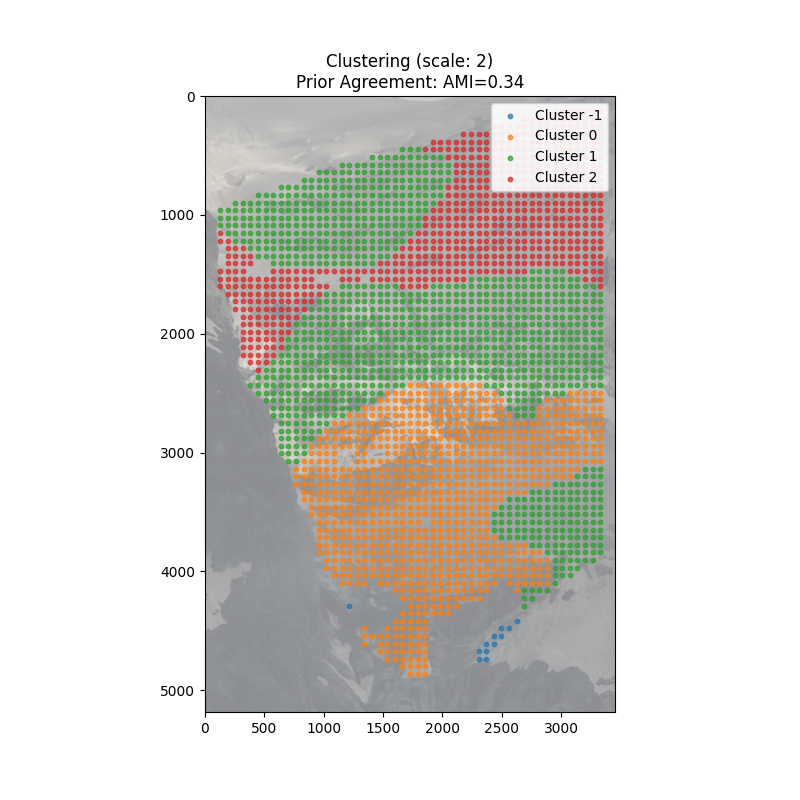

In [71]:
# === Do some post-processing on the clustering results
X, Y, label_grid = create_2d_grid(
    x=df["x"].to_numpy(), y=df["y"].to_numpy(), labels=cluster_pred, grid_spacing=None
)

# Remove small holes
min_size = 50  # Minimum size of connected components to keep
connectivity = 8  # 4 or 8 for pixel connectivity
label_grid = remove_small_grid_components(
    label_grid, min_size=min_size, connectivity=connectivity
)

# # Separate non-connected regions with same label
# label_grid, label_mapping = split_disconnected_components(
#     label_grid, connectivity=connectivity, start_label=0
# )

point_labels_cleaned, x, y = map_grid_to_points(
    X,
    Y,
    label_grid,
    x_points=df["x"].to_numpy(),
    y_points=df["y"].to_numpy(),
    keep_nan=True,
)

# === Compute similarity scores with prior clusters
# Create a "prior class" assignment based on the sector with highest probability
sector_names = list(PRIOR_PROBABILITY.keys())
sector_assignments = np.zeros_like(cluster_pred)
for i, point_probs in enumerate(prior_probs):
    sector_assignments[i] = np.argmax(point_probs)

# Compute similarity metrics
ari = adjusted_rand_score(sector_assignments, cluster_pred)
ami = adjusted_mutual_info_score(sector_assignments, cluster_pred)

# === Make final clustering plot after cleaning
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img, alpha=0.5, cmap="gray")
colormap = plt.get_cmap("tab10")
for i, label in enumerate(np.unique(point_labels_cleaned)):
    mask = point_labels_cleaned == label
    ax.scatter(
        x[mask],
        y[mask],
        color=colormap(i),
        label=f"Cluster {label}",
        s=10,
        alpha=0.7,
    )
ax.legend(loc="upper right", framealpha=0.9, fontsize=10)
ax.set_aspect("equal")


if valid_scales is not None and len(valid_scales) > 1:
    title = f"Combined Clustering (scales: {valid_scales}, stability: {stability_score if stability_score is not None else '':.2f})\nPrior Agreement: AMI={ami if ami is not None else 0.0:.2f}"
else:
    title = f"Clustering (scale: {sigma_values[0]})\nPrior Agreement: AMI={ami if ami is not None else 0.0:.2f}"

ax.set_title(title)
plt.savefig(
    output_dir
    / f"{reference_start_date}_{reference_end_date}_kinematic_clustering.png",
    dpi=300,
    bbox_inches="tight",
)
# plt.close(fig)

## FIND DISCONTINUITY IN VELOCITY FIELD


2025-09-26 14:42:54 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=1
2025-09-26 14:42:54 | [INFO    ] Estimated grid spacing: 64.00
2025-09-26 14:42:54 | [INFO    ] Created 2D grid: (75, 51), 2690 valid points
2025-09-26 14:42:54 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0


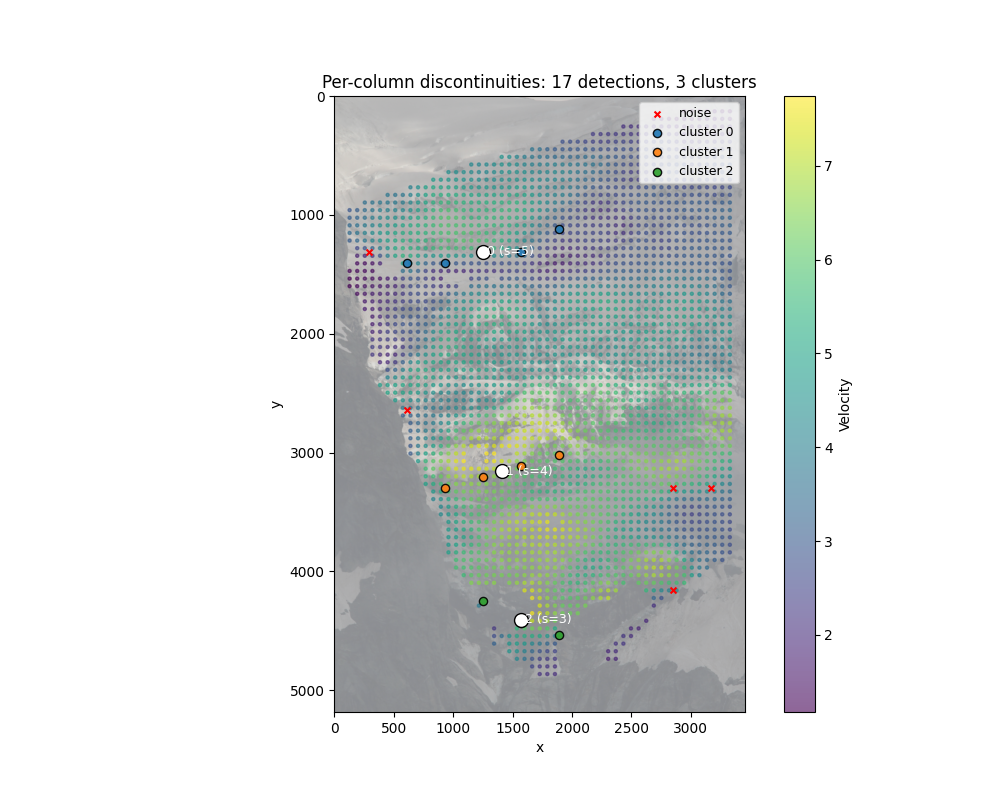

In [72]:
df_smooth = apply_2d_gaussian_filter(df, sigma=1)
x = df_smooth["x"].to_numpy()
y = df_smooth["y"].to_numpy()
v = df_smooth["V"].to_numpy()

discontinuity_results = find_vertical_discontinuities(
    x=x,
    y=y,
    v=v,
    vertical_bins=50,
    horizontal_bins=10,
    min_points_per_bin_col=20,  # try 5-20 depending on data density
    gradient_threshold_factor=0.3,  # # Threshold for significant gradient (as fraction of max) adjust to be more/less sensitive
    smoothing_sigma_1d=1.0,
    min_strength=1e-3,
    cluster_eps_factor=2.0,
    cluster_min_samples=5,
)
fig, ax = plt.subplots(figsize=(10, 8))
plot_discontinuities(
    x,
    y,
    v,
    discontinuities=discontinuity_results,
    img=img,
    ax=ax,
)


## INTEGRATE RESULTS


In [ ]:
def integrate_morpho_kinematics_v2(
    morpho_domains,
    morpho_domains_map,
    kinematics_cluster,
    x,
    y,
    boundaries=None,
    img=None,
    min_percentage=10.0,
    output_dir=None,
    base_name=None,
):
    """
    Integrate morphological domains with kinematic clusters, with velocity clusters
    defining the morpho-kinematic domain boundaries.

    Parameters:
    -----------
    morpho_domains : numpy.ndarray
        Morphological domain labels for each point (m1, m2, m3...)
    morpho_domains_map : dict
        Mapping between domain names and integer labels
    kinematics_cluster : numpy.ndarray
        Kinematic cluster labels for each point
    x, y : numpy.ndarray
        Coordinates of points
    min_percentage : float
        Minimum percentage to consider a cluster significant
    """
    # Get unique domains and clusters
    unique_morpho_domains = list(morpho_domains_map.values())
    unique_clusters = np.unique(kinematics_cluster)

    # Domain analysis dictionary
    domain_info = {}

    # Track assigned clusters to detect overlaps
    assigned_clusters = {}
    mk_domain_count = 0

    # Track all mk labels for points
    morpho_kinematic_labels = np.full_like(morpho_domains, -1)
    mk_domain_mapping = {}  # Maps (morpho_id, cluster_id) to mk_domain label

    # First pass: analyze cluster distribution in each morphological domain
    for domain_label, morpho_id in morpho_domains_map.items():
        logger.info(f"Analyzing morpho domain {domain_label} (id={morpho_id})")

        # Get points in this morpho domain
        domain_mask = morpho_domains == morpho_id
        num_domain_points = np.sum(domain_mask)

        if num_domain_points == 0:
            logger.warning(f"Domain {domain_label} has 0 points, skipping")
            continue

        # Count clusters in this domain
        cluster_counts = {}
        for cluster_id in unique_clusters:
            cluster_mask = kinematics_cluster == cluster_id
            overlap = np.sum(domain_mask & cluster_mask)
            percentage = 100 * overlap / num_domain_points

            if percentage >= min_percentage:
                cluster_counts[cluster_id] = {
                    "count": int(overlap),
                    "percentage": float(percentage),
                }

        # Sort clusters by percentage
        sorted_clusters = sorted(
            cluster_counts.items(), key=lambda x: x[1]["percentage"], reverse=True
        )

        # Store domain info for visualization
        domain_info[domain_label] = {
            "morpho_id": morpho_id,
            "cluster_distribution": cluster_counts,
            "sorted_clusters": sorted_clusters,
            "mk_domains": [],
        }

    # Second pass: assign morpho-kinematic domains based on clusters
    morpho_letter_map = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F"}

    # Process each morphological domain in order
    for domain_label, morpho_id in morpho_domains_map.items():
        if domain_label not in domain_info:
            continue

        info = domain_info[domain_label]
        sorted_clusters = info["sorted_clusters"]

        if not sorted_clusters:
            continue

        # Process primary cluster
        primary_cluster = sorted_clusters[0][0]
        primary_percentage = sorted_clusters[0][1]["percentage"]

        # Check if this cluster was already assigned to a previous morpho domain
        conflict_domain = None
        for prev_label, prev_info in domain_info.items():
            prev_morpho_id = prev_info.get("morpho_id")
            if prev_morpho_id < morpho_id:  # only check previous domains
                for mk_domain in prev_info.get("mk_domains", []):
                    if mk_domain["cluster_id"] == primary_cluster:
                        conflict_domain = prev_label
                        break
                if conflict_domain:
                    break

        # Generate morpho letter (A, B, C...)
        morpho_letter = morpho_letter_map.get(morpho_id, f"Domain{morpho_id}")

        # Create a new MK domain label
        mk_domain_count += 1
        mk_domain_label = mk_domain_count

        # Record domain info
        mk_info = {
            "mk_label": mk_domain_label,
            "morpho_id": morpho_id,
            "cluster_id": primary_cluster,
            "percentage": primary_percentage,
            "display_name": f"{morpho_letter}1",
            "conflict": conflict_domain,
        }

        info["mk_domains"].append(mk_info)
        mk_domain_mapping[(morpho_id, primary_cluster)] = mk_domain_label

        # Log warning if there's a cluster conflict
        if conflict_domain:
            logger.warning(
                f"Velocity cluster {primary_cluster} appears in both morpho domains "
                f"{conflict_domain} and {domain_label}. This may indicate hazardous conditions!"
            )

        # Assign points in morpho domain with this cluster
        mask = (morpho_domains == morpho_id) & (kinematics_cluster == primary_cluster)
        morpho_kinematic_labels[mask] = mk_domain_label

        # Process secondary cluster if it exists
        if len(sorted_clusters) > 1:
            secondary_cluster = sorted_clusters[1][0]
            secondary_percentage = sorted_clusters[1][1]["percentage"]

            if secondary_percentage >= min_percentage:
                # Check for conflicts with secondary cluster too
                secondary_conflict = None
                for prev_label, prev_info in domain_info.items():
                    prev_morpho_id = prev_info.get("morpho_id")
                    if prev_morpho_id < morpho_id:  # only check previous domains
                        for mk_domain in prev_info.get("mk_domains", []):
                            if mk_domain["cluster_id"] == secondary_cluster:
                                secondary_conflict = prev_label
                                break
                    if secondary_conflict:
                        break

                # Create a new MK domain for secondary cluster
                mk_domain_count += 1
                secondary_mk_label = mk_domain_count

                # Record secondary domain info
                mk_info = {
                    "mk_label": secondary_mk_label,
                    "morpho_id": morpho_id,
                    "cluster_id": secondary_cluster,
                    "percentage": secondary_percentage,
                    "display_name": f"{morpho_letter}2",
                    "conflict": secondary_conflict,
                }

                info["mk_domains"].append(mk_info)
                mk_domain_mapping[(morpho_id, secondary_cluster)] = secondary_mk_label

                if secondary_conflict:
                    logger.warning(
                        f"Secondary velocity cluster {secondary_cluster} in morpho domain {domain_label} "
                        f"conflicts with morpho domain {secondary_conflict}."
                    )

                # Assign points with secondary cluster
                sec_mask = (morpho_domains == morpho_id) & (
                    kinematics_cluster == secondary_cluster
                )
                morpho_kinematic_labels[sec_mask] = secondary_mk_label

    # Handle any unassigned points (clusters not covered by major morpho domains)
    unassigned_mask = morpho_kinematic_labels == -1
    if np.any(unassigned_mask):
        # Get clusters of unassigned points
        unassigned_clusters = np.unique(kinematics_cluster[unassigned_mask])
        logger.info(f"Found {len(unassigned_clusters)} unassigned velocity clusters")

        # Assign each remaining cluster to a generic domain
        for i, cluster_id in enumerate(unassigned_clusters):
            mk_domain_count += 1

            # Create a generic domain label (D1, D2, etc.)
            cluster_mask = (kinematics_cluster == cluster_id) & unassigned_mask
            morpho_kinematic_labels[cluster_mask] = mk_domain_count

            # Record this domain for visualization
            mk_info = {
                "mk_label": mk_domain_count,
                "morpho_id": None,  # No morpho domain
                "cluster_id": cluster_id,
                "percentage": 100.0,  # All points in this cluster
                "display_name": f"D{i + 1}",  # D1, D2, etc.
                "conflict": None,
            }

            # Add to a special "unassigned" category in domain_info
            if "unassigned" not in domain_info:
                domain_info["unassigned"] = {
                    "morpho_id": 999,  # Special ID for unassigned
                    "mk_domains": [],
                }
            domain_info["unassigned"]["mk_domains"].append(mk_info)

    # Create display mapping for plotting
    display_name_map = {}
    for domain_label, info in domain_info.items():
        for mk_domain in info.get("mk_domains", []):
            display_name_map[mk_domain["mk_label"]] = mk_domain["display_name"]

    # Generate visualization if requested
    if output_dir is not None and base_name is not None and img is not None:
        # Create plot for mk domains
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img, alpha=0.5, cmap="gray")

        # Use a colormap with distinct colors
        unique_mk_labels = np.unique(morpho_kinematic_labels)
        unique_mk_labels = unique_mk_labels[unique_mk_labels >= 0]  # Filter -1 if any
        n_colors = len(unique_mk_labels)
        colors = (
            plt.cm.tab20(np.linspace(0, 1, n_colors))
            if n_colors <= 20
            else plt.cm.viridis(np.linspace(0, 1, n_colors))
        )

        # Plot each MK domain
        for i, mk_label in enumerate(unique_mk_labels):
            mask = morpho_kinematic_labels == mk_label
            display_name = display_name_map.get(mk_label, f"MK{mk_label}")

            ax.scatter(
                x[mask], y[mask], color=colors[i], label=display_name, s=10, alpha=0.7
            )

        # Draw horizontal boundary lines if provided
        if boundaries is not None:
            for bound in boundaries:
                ax.axhline(y=bound, color="red", linestyle="--", alpha=0.7, linewidth=2)

        # Finalize plot
        ax.legend(loc="upper right", frameon=True, framealpha=0.9)
        ax.set_title("Morpho-Kinematic Domains")
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])

        # Save the plot
        plt.savefig(
            output_dir / f"{base_name}_mk_domains_v2.png", dpi=300, bbox_inches="tight"
        )
        # plt.close(fig)

        # Create summary table
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis("off")

        table_data = []
        table_columns = [
            "Domain",
            "Morpho Sector",
            "Velocity Cluster",
            "% Coverage",
            "Conflicts",
        ]

        # First add entries from morphological domains
        for domain_label, info in sorted(domain_info.items()):
            if domain_label == "unassigned":
                continue

            morpho_id = info.get("morpho_id")

            for mk_domain in info.get("mk_domains", []):
                table_data.append(
                    [
                        mk_domain["display_name"],
                        domain_label,
                        f"Cluster {mk_domain['cluster_id']}",
                        f"{mk_domain['percentage']:.1f}%",
                        f"Conflicts with {mk_domain['conflict']}"
                        if mk_domain["conflict"]
                        else "None",
                    ]
                )

        # Then add unassigned entries if they exist
        if "unassigned" in domain_info:
            for mk_domain in domain_info["unassigned"].get("mk_domains", []):
                table_data.append(
                    [
                        mk_domain["display_name"],
                        "None",
                        f"Cluster {mk_domain['cluster_id']}",
                        "100%",
                        "None",
                    ]
                )

        # Create and format the table
        table = ax.table(
            cellText=table_data, colLabels=table_columns, loc="center", cellLoc="center"
        )
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 2)

        # Save the table
        plt.savefig(
            output_dir / f"{base_name}_mk_domains_table_v2.png",
            dpi=200,
            bbox_inches="tight",
        )
        # plt.close(fig)

    # Return results dictionary
    return {
        "morpho_kinematic_labels": morpho_kinematic_labels,
        "domain_info": domain_info,
        "display_names": display_name_map,
        "boundaries": boundaries,
    }


# Create integrated morpho-kinematic domains with velocity clusters as primary identifiers
mk_results = integrate_morpho_kinematics_v2(
    morpho_domains=morpho_domains,
    morpho_domains_map=morpho_domains_map,
    kinematics_cluster=kinematics_cluster,
    x=x,
    y=y,
    boundaries=sorted_boundaries,
    img=img,
    min_percentage=10.0,
    output_dir=output_dir,
    base_name=f"{reference_start_date}_{reference_end_date}",
)

# Print summary of domains
print("Morpho-Kinematic Domain Summary:")
for domain_label, info in mk_results["domain_info"].items():
    if domain_label == "unassigned":
        print("\nUnassigned velocity clusters:")
    else:
        print(f"\nMorpho sector {domain_label}:")

    for mk_domain in info.get("mk_domains", []):
        print(
            f"  - {mk_domain['display_name']}: Velocity cluster {mk_domain['cluster_id']} ({mk_domain['percentage']:.1f}%)"
        )
        if mk_domain["conflict"]:
            print(
                f"    WARNING: This cluster also appears in morpho domain {mk_domain['conflict']}"
            )

In [ ]:
# Use last cluster prediction as kinematic domains
kinematics_cluster = point_labels_cleaned.copy()
x = df["x"].to_numpy()
y = df["y"].to_numpy()
v = df["V"].to_numpy()
vx = df["u"].to_numpy()
vy = df["v"].to_numpy()

# Ensure all arrays have the same length
if len(morpho_domains) != len(kinematics_cluster):
    logger.error(
        f"Shape mismatch: morpho_domains={len(morpho_domains)}, kinematics_cluster={len(kinematics_cluster)}"
    )

# Cleanup -1 labels (NaNs) from kinematics_cluster
if np.any(kinematics_cluster == -1):
    nan_mask = kinematics_cluster == -1
    morpho_domains = morpho_domains[~nan_mask]
    kinematics_cluster = kinematics_cluster[~nan_mask]
    x = x[~nan_mask]
    y = y[~nan_mask]
    v = v[~nan_mask]
    vx = vx[~nan_mask]
    vy = vy[~nan_mask]

# Get unique domains and clusters
unique_domains = list(morpho_domains_map.values())
unique_clusters = np.unique(kinematics_cluster)

In [ ]:
min_percentage = 10.0  # Minimum percentage to consider a cluster significant

# Loop over morpho domains
domain_info = {}

# domain_label, domain_id = next(iter(morpho_domains_map.items())) # For testing

for domain_label, domain_id in morpho_domains_map.items():
    logger.info(f"Analyzing morpho domain '{domain_id}' (label {domain_label})")

    domain_mask = morpho_domains == domain_id
    num_domain_points = np.sum(domain_mask)
    if num_domain_points == 0:
        logger.warning(f"Domain {domain_id} has 0 points, skipping")

    # Count clusters in this domain
    cluster_counts = {}
    for cluster in unique_clusters:
        cluster_mask = kinematics_cluster == cluster
        overlap = np.sum(domain_mask & cluster_mask)
        percentage = 100 * overlap / num_domain_points
        cluster_counts[cluster] = {
            "count": int(overlap),
            "percentage": float(percentage),
        }

    # Sort clusters by percentage and filter out negligible ones
    sorted_clusters = sorted(
        cluster_counts.items(), key=lambda x: x[1]["percentage"], reverse=True
    )

    if not sorted_clusters:
        logger.warning(f"No clusters found in domain {domain_label}, skipping")
        # continue

    # Get primary and secondary clusters (if they meet threshold)
    primary_cluster = sorted_clusters[0][0]
    primary_percentage = sorted_clusters[0][1]["percentage"]

    secondary_cluster = None
    secondary_percentage = 0
    if (
        len(sorted_clusters) > 1
        and sorted_clusters[1][1]["percentage"] >= min_percentage
    ):
        secondary_cluster = sorted_clusters[1][0]
        secondary_percentage = sorted_clusters[1][1]["percentage"]

    # Store domain info
    domain_info[domain_label] = {
        "domain_id": domain_id,
        "primary_cluster": primary_cluster,
        "primary_percentage": primary_percentage,
        "secondary_cluster": secondary_cluster,
        "secondary_percentage": secondary_percentage,
        "cluster_distribution": {
            int(k): v
            for k, v in cluster_counts.items()
            if v["percentage"] >= min_percentage
        },
    }

In [ ]:
domain_info

In [ ]:
morpho_kinematic_labels = np.zeros_like(x, dtype=int)

domain_label, domain_id = next(iter(morpho_domains_map.items()))  # For testing

for domain_label, domain_id in morpho_domains_map.items():
    logger.info(f"Assigning kinematic label for morpho domain {domain_label}")

    # Check if we have info for this domain
    if domain_label not in domain_info:
        logger.warning(f"No domain info found for label {domain_label}, skipping")
        continue  # Skip if we didn't find clusters in this domain

    domain_mask = morpho_domains == domain_id
    primary_cluster = domain_info[domain_label]["primary_cluster"]

    # Create combined label (domain*10 + cluster)
    # This gives us labels like: 01, 02, 11, 12, 21, etc.
    morpho_kinematic_labels[domain_mask] = domain_id * 10 + primary_cluster


In [ ]:
morpho_kinematic_labels


In [ ]:
# Plot integrated domains
fig, ax = plt.subplots(figsize=(10, 10))

if img is not None:
    ax.imshow(img, alpha=0.5, cmap="gray")

# Create colormap with distinct colors for each morpho-kinematic unit
unique_mk_labels = np.unique(morpho_kinematic_labels)
mk_colors = colormap(np.linspace(0, 1, len(unique_mk_labels)))

# Plot each morpho-kinematic unit
for i, mk_label in enumerate(unique_mk_labels):
    mask = morpho_kinematic_labels == mk_label
    domain_id = mk_label // 10
    cluster_id = mk_label % 10
    domain_name = ["A", "B", "C", "D"][domain_id] if domain_id < 4 else f"D{domain_id}"

    ax.scatter(
        x[mask],
        y[mask],
        color=mk_colors[i],
        label=f"Domain {domain_name}-K{cluster_id}",
        s=10,
        alpha=0.7,
    )

# Draw boundaries
for bound in boundaries:
    ax.axhline(y=bound, color="red", linestyle="--", alpha=0.7, linewidth=2)

ax.legend(loc="upper right", frameon=True, framealpha=0.9)
ax.set_title("Integrated Morpho-Kinematic Domains")
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

# plt.savefig(
#     output_dir / f"{base_name}_morpho_kinematic_domains.png",
#     dpi=300,
#     bbox_inches="tight",
# )
# plt.close(fig)

In [ ]:
# Create table showing domain characteristics
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
table_data = []
table_columns = [
    "Domain",
    "Primary Cluster",
    "Primary %",
    "Secondary Cluster",
    "Secondary %",
]

for domain_name, info in domain_info.items():
    secondary = (
        f"{info['secondary_cluster']} ({info['secondary_percentage']:.1f}%)"
        if info["secondary_cluster"] is not None
        else "None"
    )
    table_data.append(
        [
            domain_name,
            f"{info['primary_cluster']}",
            f"{info['primary_percentage']:.1f}%",
            secondary.split()[0] if secondary != "None" else "None",
            f"{info['secondary_percentage']:.1f}%"
            if info["secondary_cluster"] is not None
            else "0%",
        ]
    )

table = ax.table(
    cellText=table_data, colLabels=table_columns, loc="center", cellLoc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)

# plt.savefig(
#     output_dir / f"{base_name}_domain_statistics.png",
#     dpi=200,
#     bbox_inches="tight",
# )
# plt.close(fig)
